In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K
from keras.layers import Input
from keras import models
from keras import layers
from keras import optimizers
import random 
from keras.preprocessing.image import ImageDataGenerator
from random import randrange
import cv2
from keras import backend as K
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.applications.vgg19 import VGG19
from keras.preprocessing import image
from keras.applications.vgg19 import preprocess_input
from keras.layers import Activation, Flatten, Dropout, BatchNormalization
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [112]:
#ls -l

In [113]:
#df = pd.read_fwf('myexp.txt')
#df.to_csv('myexp.csv')

In [114]:
#df = pd.read_excel("./example.xlsx")

In [115]:
#df.to_csv("./m_f.csv", sep=",")

In [6]:
dat = pd.read_csv('m_f_labels.csv')

In [7]:
dat.head()

dat.columns

Index(['Unnamed: 0', 'full_path', 'image_name', 'gender_Female', 'gender_Male',
       'age_20_30', 'age_30_40', 'age_40_50', 'age_50_60', 'age_10_20'],
      dtype='object')

In [8]:
X = dat['image_name']
y = dat[['gender_Female', 'gender_Male', 'age_20_30', 'age_30_40', 'age_40_50', 'age_50_60', 'age_10_20']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=62)


In [9]:
y_train.columns

Index(['gender_Female', 'gender_Male', 'age_20_30', 'age_30_40', 'age_40_50',
       'age_50_60', 'age_10_20'],
      dtype='object')

In [10]:
X_train = X_train.values.tolist()
X_test = X_test.values.tolist()

#train

gender = ['gender_Female',
       'gender_Male']
gender_train = y_train[gender]
gender_nodes = gender_train.shape[1]
gender_train = gender_train.values.tolist()

age = ['age_20_30', 'age_30_40', 'age_40_50', 'age_50_60', 'age_10_20']
age_train = y_train[age]
age_nodes = age_train.shape[1]
age_train = age_train.values.tolist()

print(gender_nodes, age_nodes)

#test


#train

gender = ['gender_Female',
       'gender_Male']
gender_test = y_test[gender]
gender_nodes = gender_test.shape[1]
gender_test = gender_test.values.tolist()

age = ['age_20_30', 'age_30_40', 'age_40_50', 'age_50_60', 'age_10_20']
age_test = y_test[age]
age_nodes = age_test.shape[1]
age_test = age_test.values.tolist()

print(gender_nodes, age_nodes)

2 5
2 5


In [11]:
# initialize the number of epochs and batch size
EPOCHS = 100
BS = 36

def image_generator_fgo(king_of_lists, bs, mode="train", aug=None):
    # loop indefinitely
    
    while True:
        # initialize our batches of images and labels
        images = []
        #labels = []
        
        gender = []
        age = []
                
        # keep looping until we reach our batch size
        while len(images) < bs:
            combined_label_list = []
            random_index = randrange(len(king_of_lists[0]))
            img = image.load_img('input_image/'+king_of_lists[0][random_index],target_size=(224, 224)) #read in image
            img = image.img_to_array(img)
            img = preprocess_input(img)
            
            gender.append(king_of_lists[1][random_index]) # gender
            age.append(np.array(king_of_lists[2][random_index])) # age
            
            images.append(img)
            
        labels = [np.array(gender),np.array(age)]
        # if the data augmentation object is not None, apply it
        #labels
        if aug is not None:
            (images, labels) = next(aug.flow(np.array(images),labels, batch_size=bs))
        #print(labels.shape)
        # yield the batch to the calling function
        yield np.array(images),  labels
        
# construct the training image generator for data augmentation
aug = ImageDataGenerator(rotation_range=20, zoom_range=0.15,
                         width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15,
                         horizontal_flip=True, fill_mode="nearest")

train_lists = [X_train, gender_train, age_train]
test_lists = [X_test, gender_test, age_test]
# initialize both the training and testing image generators
trainGen = image_generator_fgo(train_lists, BS, 
                               mode="train", aug=None)
testGen = image_generator_fgo(test_lists, BS, 
                              mode="train", aug=None)

In [12]:
# Color Images, Multi-Label Targets
from keras.optimizers import SGD, Adam

loss_list = ["categorical_crossentropy",'categorical_crossentropy']

test_metrics = {'gender': 'accuracy','age': 'accuracy'}
dd = 0.0
import math
def step_decay(epoch):
   initial_lrate = 0.01
   drop = 0.5
   epochs_drop = 5.0
   lrate = initial_lrate * math.pow(drop,  
           math.floor((1+epoch)/epochs_drop))
   return lrate
def multi_model(loss_list,test_metrics,dd):
    
    base_model = VGG19(weights='imagenet', include_top=False)

    #freeze all the layers
    for layer in base_model.layers[:]:
       layer.trainable = False

    
    model_input = Input(shape=(224, 224, 3))
    x = base_model(model_input)
    x = GlobalAveragePooling2D()(x)
    
    # let's add a fully-connected layer
    x = Dense(256, activation='relu')(x)
    x = Dropout(dd)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(dd)(x)
    
    # start passing that fully connected block output to all the 
    # different model heads
    y1 = Dense(128, activation='relu')(x)
    y1 = Dropout(dd)(y1)
    y1 = Dense(64, activation='relu')(y1)
    y1 = Dropout(dd)(y1)
    
    y2 = Dense(128, activation='relu')(x)
    y2 = Dropout(dd)(y2)
    y2 = Dense(64, activation='relu')(y2)
    y2 = Dropout(dd)(y2)
    
    #connect all the heads to their final output layers
    y1 = Dense(gender_nodes, activation='softmax',name= 'gender')(y1)
    y2 = Dense(age_nodes, activation='softmax',name= 'age')(y2)
    
    model = Model(inputs=model_input, outputs=[ y1, y2])
    
    model.compile(loss=loss_list, optimizer=SGD(lr=0.01,momentum=0.9), metrics=test_metrics)

    return model

multi_model = multi_model(loss_list,test_metrics,dd)

multi_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
vgg19 (Model)                   multiple             20024384    input_2[0][0]                    
__________________________________________________________________________________________________
global_average_pooling2d_1 (Glo (None, 512)          0           vgg19[1][0]                      
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 256)          131328      global_average_pooling2d_1[0][0] 
__________________________________________________________________________________________________
dropout_1 

In [13]:
print(multi_model.metrics_names)

['loss', 'gender_loss', 'age_loss', 'gender_acc', 'age_acc']


In [124]:
checkpoint = ModelCheckpoint('models/best_run7_smaller.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
lrate = LearningRateScheduler(step_decay)
callbacks_list = [checkpoint,lrate]
multi_model.fit_generator(trainGen,steps_per_epoch=len(X_train) // BS,
                    validation_data=testGen,
                    validation_steps=len(X_test) // BS,
                    epochs=EPOCHS,callbacks=callbacks_list)

Epoch 1/5


KeyboardInterrupt: 

In [14]:
from keras.models import load_model
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
%pylab inline

Populating the interactive namespace from numpy and matplotlib


F:\anaconda_python\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['test', 'random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [15]:
model = load_model('models/best_run77_smaller.h5')

In [16]:
def extract_label(label_list, pred_array):
    pred_max = pred_array.argmax()
    
    return label_list[pred_max]

g1.jpg

image:  g1.jpg
gender_Male
age_40_50


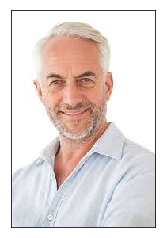

g13.jpg

image:  g13.jpg
gender_Female
age_20_30


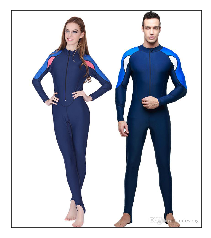

g15.jpg

image:  g15.jpg
gender_Female
age_20_30


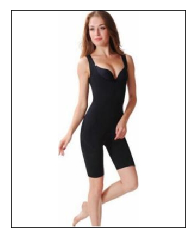

g16.jpg

image:  g16.jpg
gender_Female
age_30_40


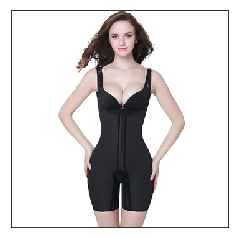

g2.jpg

image:  g2.jpg
gender_Male
age_50_60


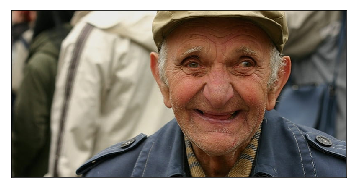

g21.jpg

image:  g21.jpg
gender_Female
age_10_20


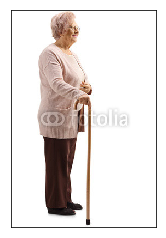

g26.jpg

image:  g26.jpg
gender_Female
age_50_60


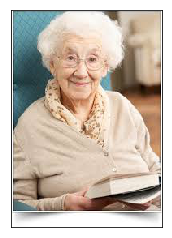

g3.jpg

image:  g3.jpg
gender_Male
age_20_30


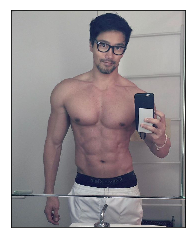

g4.jpg

image:  g4.jpg
gender_Male
age_20_30


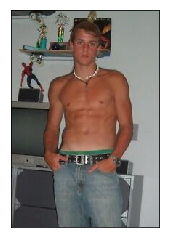

g5.jpg

image:  g5.jpg
gender_Male
age_20_30


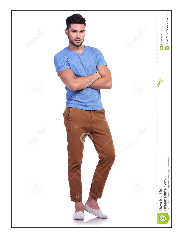

g7,jpg.jpg

image:  g7,jpg.jpg
gender_Female
age_20_30


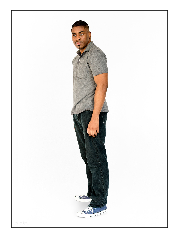

g8.jpg

image:  g8.jpg
gender_Female
age_20_30


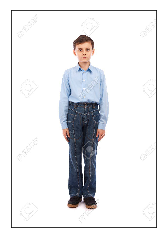

p1.jpg

image:  p1.jpg
gender_Male
age_40_50


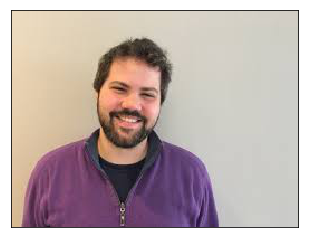

p10.jpg

image:  p10.jpg
gender_Male
age_20_30


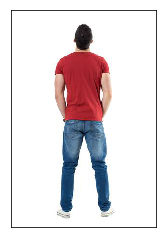

p11.jpg

image:  p11.jpg
gender_Female
age_20_30


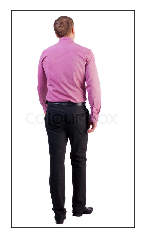

p15.jpg

image:  p15.jpg
gender_Female
age_20_30


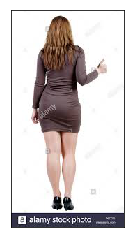

p17.jpg

image:  p17.jpg
gender_Female
age_20_30


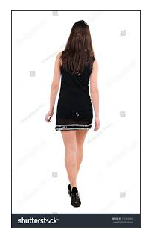

p2.jpg

image:  p2.jpg
gender_Male
age_40_50


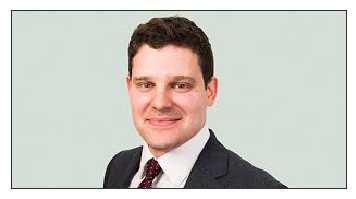

p3.jpg

image:  p3.jpg
gender_Male
age_40_50


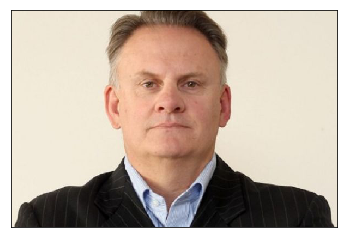

p4.jpg

image:  p4.jpg
gender_Female
age_20_30


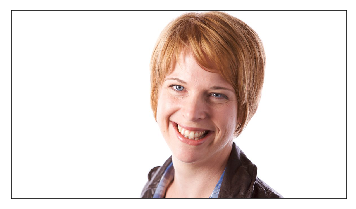

p5.jpg

image:  p5.jpg
gender_Female
age_20_30


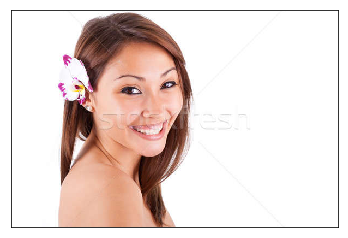

p6.jpg

image:  p6.jpg
gender_Female
age_20_30


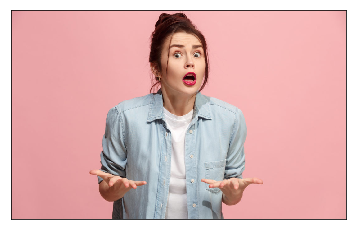

p7.jpg

image:  p7.jpg
gender_Female
age_20_30


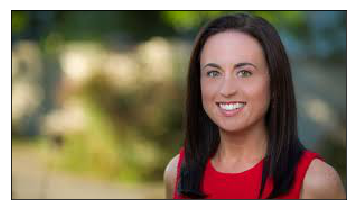

In [18]:
from os import listdir

test = listdir('test/')
    
for i in test:
    img = image.load_img('test/'+i,target_size=(224, 224)) #read in image
    img = image.img_to_array(img)
    img = preprocess_input(img)
    prediction = model.predict(np.array([img]))
    print(i)
    
    
    print('')
    print('image: ', i )
    print(extract_label(gender, prediction[0]))
    print(extract_label(age, prediction[1]))
   
    
    im2 = image.load_img('test/'+i)
    plt.imshow(im2)
    plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
    plt.show()